  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

average sum : 147.81
average old : 19.7
average sum : 61.416666666666664
average old : 11.816666666666666
average sum : 63.22666666666667
average old : 11.433333333333334
average sum : 47.10333333333333
average old : 9.793333333333333
79.88916666666667
13.185833333333335


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


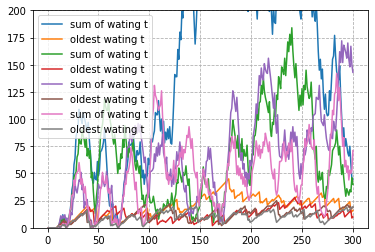

In [18]:
import Junction2x2
import Agent
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import torch

train = False
epoch = 20000 if train else 1
agent = [0,0,0,0]
# agent[0] = Agent.DQNAgent(state_size=28, action_size=8, train=train)
# agent[1] = Agent.DQNAgent(state_size=28, action_size=8, train=train)
# agent[2] = Agent.DQNAgent(state_size=28, action_size=8, train=train)
# agent[3] = Agent.DQNAgent(state_size=28, action_size=8, train=train)
agent[0] = Agent.DQNAgent(state_size=28, action_size=8, train=False, state_dict=torch.load("test/0.pth"))
agent[1] = Agent.DQNAgent(state_size=28, action_size=8, train=False, state_dict=torch.load("test/1.pth"))
agent[2] = Agent.DQNAgent(state_size=28, action_size=8, train=False, state_dict=torch.load("test/2.pth"))
agent[3] = Agent.DQNAgent(state_size=28, action_size=8, train=False, state_dict=torch.load("test/3.pth"))
reward_info, step_info, longest_wait = [[] for i in range(4)], [], [[] for i in range(4)]
avg_rewards, avg_steps, avg_long_wait = [0, 0, 0, 0], 0, [0, 0, 0, 0]


for i in tqdm(range(epoch)):
    env = Junction2x2.Junction2x2()
    r, l = [0, 0, 0, 0], [0, 0, 0, 0]
    for step in range(300):
        states = list()
        actions = list()
        for j in range(4):
            state = env.get_adjusted_state(j)
            states.append(state)
            action = agent[j].get_action(state)
            actions.append(action)

        j1,j2,j3,j4 = env.step(actions)
        J = [j1,j2,j3,j4]
        if train:
            for j in range(4):
                next_state, reward, done = J[j]
                agent[j].append_sample(states[j], actions[j], reward, next_state, done)
                agent[j].train_model()
                r[j] += reward
                l[j] = max(l[j], env.J[j].get_oldest())

        done_list = [j1[2], j2[2], j3[2], j4[2]]
        if any(done_list):
            break
#         if not train:
#             print(env.render())
#             sleep(0.1)

    if not train:
        aaa = list()
        bbb = list()
        for j in range(4):
            env.J[j].save_graph(f"performance/performance{j}.png")
            info = np.array(env.J[j].info)
            t, w, o = info[:, 0], info[:, 1], info[:, 2]
            aaa.append(sum(w)/t[-1])
            bbb.append(sum(o)/t[-1])
        print(sum(aaa)/len(aaa))
        print(sum(bbb)/len(bbb))
    
    if train:
        if i % 500 == 499:
            for j in range(4):
                torch.save(agent[j].model.state_dict(), f"weight/save{j}_{i + 1}.pth")
                
        for j in range(4):
            avg_rewards[j] = r[j] if avg_rewards[j] == 0 else avg_rewards[j] * 0.9 + r[j] * 0.1
            avg_long_wait[j] = l[j] if avg_long_wait[j] == 0 else avg_long_wait[j] * 0.9 + l[j] * 0.1
        avg_steps = (step + 1) if avg_steps == 0 else avg_steps * 0.9 + (step + 1) * 0.1

        for j in range(4):
            reward_info[j].append(avg_rewards[j])
            longest_wait[j].append(avg_long_wait[j])
        step_info.append(avg_steps)

        if i % 500 == 499:
            fig = plt.figure()
            for j in range(4):
                plt.subplot(2, 2, j + 1)
                plt.scatter(range(len(reward_info[j])), reward_info[j], s=1)

                plt.savefig(f"graph/reward{i + 1}.png")
            plt.clf()

            for j in range(4):
                plt.subplot(2, 2, j + 1)
                plt.scatter(range(len(longest_wait[j])), longest_wait[j], s=1)

                plt.savefig(f"graph/longest_wait{i + 1}.png")
            plt.clf()

            plt.scatter(range(len(step_info)), step_info, s=1)
            plt.savefig(f"graph/step{i + 1}.png")
            plt.clf()


